## pen_pencil dataset classification using Transfer Learning

In this notebook, we will explore how Tranfer Learning can be of help when we have smaller dataset or not sufficient dataset.

We can harness the capabilities of pretrained model trained on large scaled dataset in different ways:
- use the pretrained model as it is - if your dataset is quite similar to what pretrained model is trained on.
- extract feature vector from the pretrained model, then add you task specific output layer.
- fine tuning - means you would train few or all layer as required for your task

We will use feature vector of images with PNASNet-5 (large) trained on ImageNet (ILSVRC-2012-CLS).,
- has a metric value of 82.9% and #Global ank 404 as of 19/07/2023

For more details
- ImageNet: https://www.image-net.org/challenges/LSVRC/2012/
- Refer Paper: [Progressive Neural Architecture Search](https://arxiv.org/pdf/1712.00559v3.pdf)
- PNASNet: https://paperswithcode.com/model/pnasnet?variant=pnasnet5large

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

### Data Download

In [ ]:
#Data download
!wget --no-check-certificate   https://github.com/JSini/pen_pencil_image_dataset/archive/refs/heads/main.zip

--2023-07-19 15:20:02--  https://github.com/JSini/pen_pencil_image_dataset/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/JSini/pen_pencil_image_dataset/zip/refs/heads/main [following]
--2023-07-19 15:20:02--  https://codeload.github.com/JSini/pen_pencil_image_dataset/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [    <=>             ]  22.59M  28.8MB/s    in 0.8s    

2023-07-19 15:20:03 (28.8 MB/s) - ‘main.zip’ saved [23684120]



In [ ]:
import zipfile
import os

In [ ]:
# unzip the data file
local = '/content/main.zip'
zip_ref = zipfile.ZipFile(local)
zip_ref.extractall()
zip_ref.close()

In [ ]:
##define directories
root_dir = '/content/pen_pencil_image_dataset-main/data'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

### Understanding Data

In [ ]:
# lets walk thorugh the directory tree
for dirpath, dirs, files, in os.walk(root_dir):
    print(f"There are {len(dirs)} directories, {len(files)} images in {dirpath}")

There are 2 directories, 0 images in /content/pen_pencil_image_dataset-main/data
There are 2 directories, 0 images in /content/pen_pencil_image_dataset-main/data/train
There are 0 directories, 10 images in /content/pen_pencil_image_dataset-main/data/train/pen
There are 0 directories, 10 images in /content/pen_pencil_image_dataset-main/data/train/pencil
There are 2 directories, 0 images in /content/pen_pencil_image_dataset-main/data/test
There are 0 directories, 3 images in /content/pen_pencil_image_dataset-main/data/test/pen
There are 0 directories, 3 images in /content/pen_pencil_image_dataset-main/data/test/pencil


In [ ]:
class_names = os.listdir(train_dir)
class_names

['pen', 'pencil']

In [ ]:
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

## we have the target class names, so we write a function to display classes images from train

def display_images(target_dir, target_class):
    path_to_img_class = os.path.join(target_dir, target_class)
    n_images = len(os.listdir(path_to_img_class))

    random_img = random.choice(os.listdir(path_to_img_class)[0:n_images])
    img_path = os.path.join(path_to_img_class, random_img)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis(False)

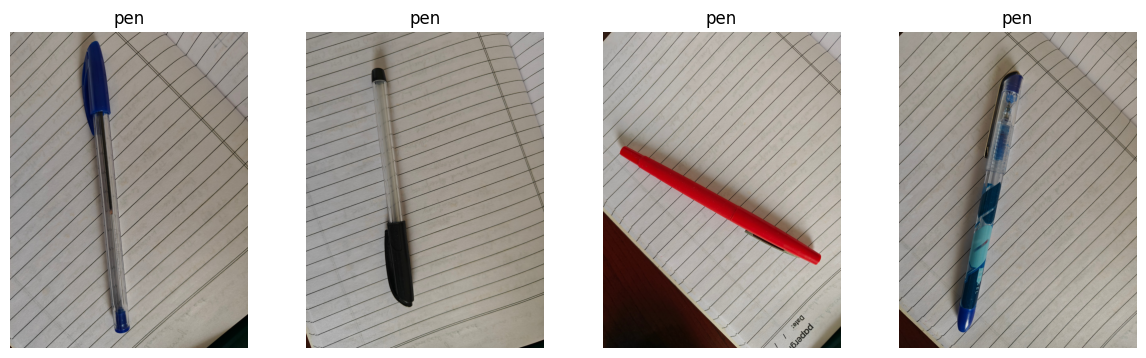

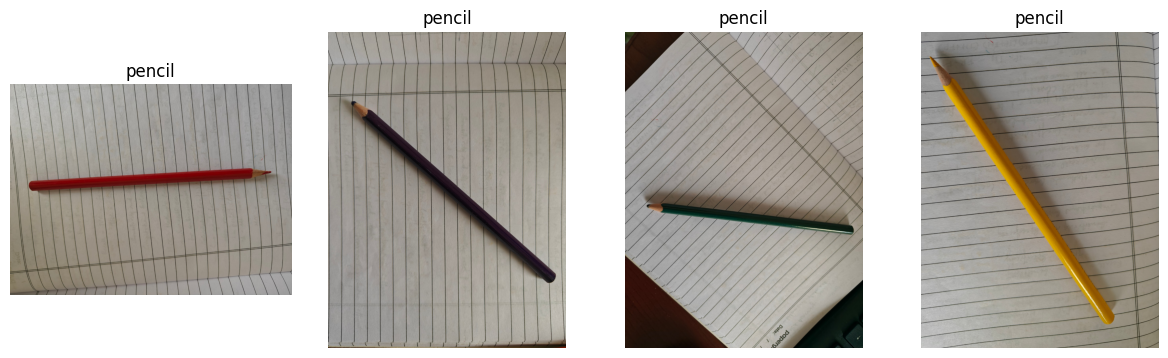

In [ ]:
# View random 10 images from 10 classes each time you run the code
nrows=2
ncols=4

for c in class_names:
    plt.figure(figsize=(12,7))
    for i in range(4):
        plt.subplot(nrows, ncols, i+1)
        display_images(train_dir, c)
        plt.title(c)
    plt.tight_layout()
    plt.show()


###Prepare data using ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator



**Important points to Note**:
- The input images are expected to have color values in the range `[0,1]`, following the common image input conventions.
- For this model, the size of the input images is fixed to height x width = 331 x 331 pixels.

In [ ]:
## Create data generators
IMAGE_SHAPE=(331,331) # as required as input size for PNASNet-5 model

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_gen = train_datagen.flow_from_directory(train_dir,
                                              class_mode='binary',
                                              target_size=IMAGE_SHAPE,
                                              batch_size=1,
                                              shuffle=True)

test_gen = train_datagen.flow_from_directory(test_dir,
                                              class_mode='binary',
                                              target_size=IMAGE_SHAPE,
                                              batch_size=1)

Found 20 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [ ]:
image, label = train_gen.next()
image.shape, label.shape

((1, 331, 331, 3), (1,))

### Model building and training

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

In [ ]:
## PNASNet-5 feature vector url from tensorhub
p_nasnet_url = 'https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/5'

In [ ]:
input_shape = (IMAGE_SHAPE + (3,))

## Defining function which takes the tensorflow hub  url and creates a keras sequential model
def create_model(url, n_classes=10):
    ## download pretrained model and save it as keras layer
    feature_extraction_layer = hub.KerasLayer(url,
                                              trainable=False,
                                              name='feature_extraction_layers',
                                              input_shape=input_shape)

    model = tf.keras.Sequential([
        feature_extraction_layer,
        tf.keras.layers.Dense(n_classes, activation='sigmoid') # binary classification task
    ])

    return model

In [ ]:
# Creating p_nasenetv5_model for binary classification task
p_nasnet_v5_model = create_model(p_nasnet_url, n_classes=1)

In [ ]:
# Compile model
p_nasnet_v5_model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])

In [ ]:
import datetime
# Code source
# https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/scalars_and_keras.ipynb#scrollTo=VmEQwCon3i7m
# https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/video_notebooks/04_transfer_learning_in_tensorflow_part_1_feature_extraction_video.ipynb
# Create tensorboard callback function

def create_tensorboard_callback(dirname, experiment_name):
    log_dir = dirname + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [ ]:
# Saving directory for logs
SAVE_DIR = 'tensorflow_hub_pen_pencil_classification'

# Fit the model
history_p_nasnet_v5_model = p_nasnet_v5_model.fit(train_gen,
                                                  epochs=10,
                                                  validation_data=test_gen,
                                                  callbacks=[create_tensorboard_callback(SAVE_DIR, 'p_nasnet_v5_model')])

Saving TensorBoard log files to: tensorflow_hub_pen_pencil_classification/p_nasnet_v5_model/20230719-152220
Epoch 1/10
20/20 [==============================] - 75s 3s/step - loss: 0.6998 - accuracy: 0.5500 - val_loss: 0.5166 - val_accuracy: 0.8333
Epoch 2/10
20/20 [==============================] - 39s 2s/step - loss: 0.4229 - accuracy: 0.8500 - val_loss: 0.3006 - val_accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 38s 2s/step - loss: 0.2763 - accuracy: 0.9500 - val_loss: 0.2279 - val_accuracy: 1.0000
Epoch 4/10
20/20 [==============================] - 39s 2s/step - loss: 0.2282 - accuracy: 0.9000 - val_loss: 0.1609 - val_accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 39s 2s/step - loss: 0.2010 - accuracy: 0.9500 - val_loss: 0.1295 - val_accuracy: 1.0000
Epoch 6/10
20/20 [==============================] - 39s 2s/step - loss: 0.1740 - accuracy: 0.9500 - val_loss: 0.1198 - val_accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 

### Model Evaluation

In [ ]:
results_p_nasnet_v5_model = p_nasnet_v5_model.evaluate(test_gen)
results_p_nasnet_v5_model

6/6 [==============================] - 9s 1s/step - loss: 0.0741 - accuracy: 1.0000


[0.07406257838010788, 1.0]

In [ ]:
# lets code up a function to plot_learning curves

def plot_train_val_curves(history):
    """
    Function plot learning curves(loss curve and accuracy curve) for train and validation from the model training
    Argument:
      history: histroy the return object from model.fit(), dictionary of model performance logs
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    n_epochs = range(len(loss))

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(n_epochs, loss, label='train_loss')
    plt.plot(n_epochs, val_loss, label='val_loss')
    plt.grid()
    plt.legend()
    plt.title("Loss Curves")
    plt.xlabel('epochs')
    plt.ylabel('metric')
    plt.subplot(1, 2, 2)
    plt.plot(n_epochs, acc, label='train_accuracy')
    plt.plot(n_epochs, val_acc, label='val_accuracy')
    plt.grid()
    plt.legend()
    plt.xlabel('epochs')
    plt.title("Accuracy Curves")


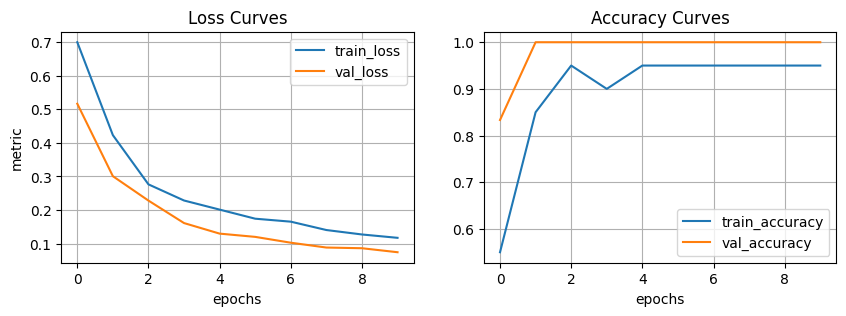

In [ ]:
plot_train_val_curves(history_p_nasnet_v5_model)

Loss and accuracy curves trends look good

In [ ]:
## Save model
p_nasnet_v5_model.save('p_nasnet_v5_model')

In [ ]:
# Copying model to drive
!cp -r '/content/p_nasnet_v5_model' '/content/drive/MyDrive/Image_Classification_pen_pencil_dataset'

In [ ]:
# Loading  model from drive
model_PNASNet_5_loaded = tf.keras.models.load_model('/content/drive/MyDrive/Image_Classification_pen_pencil_dataset/p_nasnet_v5_model')

In [ ]:
# Evaluating loaded model
model_PNASNet_5_loaded.evaluate(test_gen)

6/6 [==============================] - 15s 2s/step - loss: 0.0741 - accuracy: 1.0000


[0.07406257838010788, 1.0]

result same as the saved 'p_nasnet_v5_model'

### Uploading results to Tensorboard

In [ ]:
## Uploading results to Tensorboard
!tensorboard dev upload --logdir ./tensorflow_hub_pen_pencil_classification \
  --name 'PNASNet-5 transfer learning' \
  --description 'Transfer learning using PNASNet-5 on tiny dataset of pen-pencil images' \
  --one_shot

###Make Prediction On Test Images - The Real Test

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image


def predict_image_class(model, img):

    # Prepare image input
    img = image.load_img(img, target_size=(331, 331))
    plt.imshow(img)
    x = image.img_to_array(img) # image to array
    x = x/255. # normalizing

    input_x = tf.expand_dims(x, 0) # expanding dimension to include batch dim

    # Make prediction
    pred_prob = model.predict(input_x, verbose=0)
    pred_class = tf.round(pred_prob)[0].numpy()
    #print(f"Predicted class:{class_names[int(pred_class)]}")
    plt.title(class_names[int(pred_class)])

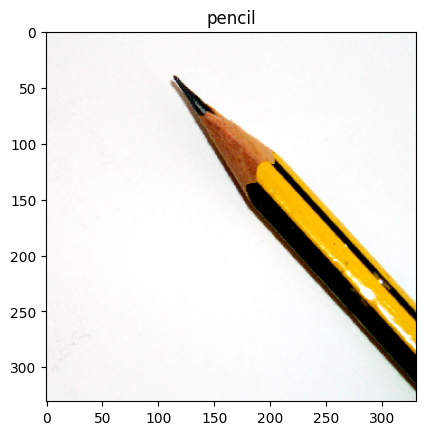

In [ ]:
## Testing single test case
model = p_nasnet_v5_model
img = '/content/pencil-1-1313120.jpg'
predict_image_class(model, img)

In [ ]:
## Unzip test images zip file
local = '/content/pen_pencil_test_unseen.zip'
zip_ref = zipfile.ZipFile(local)
zip_ref.extractall()
zip_ref.close()


In [ ]:
# Test images list
test_images_list = os.listdir('/content/pen_pencil_test_unseen')
test_images_list

['book-1558780.jpg',
 'pencil-1-1313120.jpg',
 'color-pencil-1546438.jpg',
 'pen-1315749.jpg',
 'pen-1239384.jpg',
 'pencil-1311782.jpg',
 'pencil-1240842.jpg',
 'pen-1313227.jpg',
 'pen.jpg',
 'colored-pencil-1194122.jpg']

In [ ]:
len(test_images_list)

10

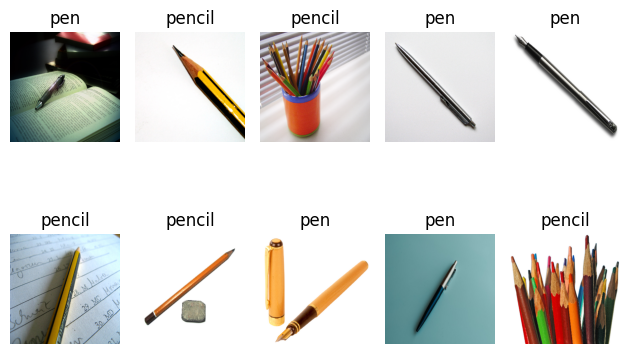

In [ ]:
nrows=2
ncols=5

for e, img in enumerate(test_images_list):
    plt.subplot(nrows, ncols, e+1)
    predict_image_class(model, img)
    plt.axis(False)
plt.tight_layout()

Result seems to be perfect

Curious to look for pen and pencil in ImageNet class list? Me too!!!
Here is the list- https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
- We do see pen as one of the class but no pencil
So, yes the Transfer learning did a great job for the classification task with just 10 images per class!!

In [2]:
## Goodbye note
print("Truth will set you Free. John 8:31-32 ")
print("Thank you Jesus!!")

Truth will set you Free. John 8:31-32 
Thank you Jesus!!
